In [1]:
import os
import cv2
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, Conv3DTranspose, BatchNormalization, Activation, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import scipy.io
import gc

2024-07-11 14:20:57.789471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 14:20:57.789590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 14:20:57.919861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img = cv2.imread('/kaggle/input/ucsd-data/UCSDped1/UCSDped1/Train/Train001/002.tif')
img.shape

(158, 238, 3)

In [3]:
train_frames=[]
for j in range(1,35):
    for i in range(1,201): #total test frames
        print(i)    
        frame=cv2.imread('/kaggle/input/ucsd-data/UCSDped1/UCSDped1/Train/Train'+'{:03d}'.format(j) + '/{:03d}.tif'.format(i),0) #path
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (224,224))
        train_frames.append(frame)
train_frames=np.array(train_frames)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


In [4]:
train_frames.shape

(6800, 224, 224)

In [5]:
X_train=[]
for i in range(0,len(train_frames),10):
    X_train.append(train_frames[i:i+10])
X_train=np.array(X_train)
X_train.shape

(680, 10, 224, 224)

In [6]:
X_train = X_train / 255.0  # Normalize

In [7]:
X_train.shape

(680, 10, 224, 224)

In [8]:
# Define input shape
input_shape = (10, 224, 224, 1)

# Build the autoencoder model
input_img = Input(shape=input_shape)

# Encoder layers (same as before)
x = Conv3D(64, kernel_size=(3, 3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv3D(32, kernel_size=(3, 3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv3D(16, kernel_size=(3, 3, 3), padding='same')(x)
x = BatchNormalization()(x)
encoded = Activation('relu')(x)

# Decoder layers
x = Conv3DTranspose(16, kernel_size=(3, 3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv3DTranspose(32, kernel_size=(3, 3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv3DTranspose(64, kernel_size=(3, 3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Conv3DTranspose(1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Print model summary
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 224, 224,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 10, 224, 224,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 224, 224,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10, 224, 224,   │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 224, 224,   │        55,328 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 224, 224,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10, 224, 224,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 10, 224, 224,   │        13,840 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 224, 224,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10, 224, 224,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose                │ (None, 10, 224, 224,   │         6,928 │
│ (Conv3DTranspose)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 224, 224,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10, 224, 224,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_1              │ (None, 10, 224, 224,   │        13,856 │
│ (Conv3DTranspose)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 224, 224,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 10, 224, 224,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_2              │ (None, 10, 224, 224,   │        55,36

 Total params: 149,729 (584.88 KB)

 Trainable params: 149,281 (583.13 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# Define callbacks
checkpoint = ModelCheckpoint('autoencoder.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Train the model
epochs = 40
batch_size = 4
history = autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[checkpoint, early_stopping])

# Save the trained model
autoencoder.save('autoencoder_trained.h5')

Epoch 1/40


2024-07-11 14:22:48.037185: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[4,32,10,224,224]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,10,224,224]{4,3,2,1,0}, f32[32,64,3,3,3]{4,3,2,1,0}, f32[32]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-11 14:22:48.039629: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.002528054s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[4,32,10,224,224]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,10,224,224]{4,3,2,1,0}, f32[32,64,3,3,3]{4,3,2,1,0}, f32[32]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","s

153/153 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - loss: 0.0132 - val_loss: 0.0310
Epoch 2/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 7.7289e-04 - val_loss: 0.0230
Epoch 3/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 4.0786e-04 - val_loss: 0.0103
Epoch 4/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 3.7979e-04 - val_loss: 0.0021
Epoch 5/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 3.5597e-04 - val_loss: 2.5572e-04
Epoch 6/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 2.3688e-04 - val_loss: 1.8497e-04
Epoch 7/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 2.1788e-04 - val_loss: 1.5557e-04
Epoch 8/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 2.6032e-04 - val_loss: 1.7260e-04
Epoch 9/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 2.1627e-04 - val_loss: 1.6170e-04
Epoch 10/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 1.9946e-04 - val_loss: 1.2246e-04
Epoch 11/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 1.8639e-04 - val_l

In [10]:
# Clear memory
del autoencoder
tf.keras.backend.clear_session()
gc.collect()

0

In [32]:
test_frames=[]
for j in range(1,37):
    for i in range(1,201): #total test frames
#         print(i)    
        frame=cv2.imread('/kaggle/input/ucsd-data/UCSDped1/UCSDped1/Test/Test'+'{:03d}'.format(j) + '/{:03d}.tif'.format(i),0) #path
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (224,224))
        test_frames.append(frame)
test_frames=np.array(test_frames)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


In [33]:
X_test=[]
for i in range(0,len(test_frames),10):
    X_test.append(test_frames[i:i+10])
X_test=np.array(X_test)
X_test.shape

(720, 10, 224, 224)

In [34]:
X_test = X_test / 255.0  # Normalize

In [35]:
from tensorflow.keras.models import load_model

In [36]:
# Load the trained model
model = load_model('/kaggle/working/autoencoder.keras')

In [37]:
batch_size = 8  # Adjust batch size as per your GPU memory capacity
num_samples = X_test.shape[0]
predictions = []
for i in range(0, num_samples, batch_size):
    batch_pred = model.predict(X_test[i:i+batch_size])
    predictions.append(batch_pred)

X_pred = np.concatenate(predictions, axis=0)

2024-07-11 16:05:54.444792: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[8,16,10,224,224]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,10,224,224]{4,3,2,1,0}, f32[16,32,3,3,3]{4,3,2,1,0}, f32[16]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-11 16:05:54.550816: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.10611787s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[8,16,10,224,224]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,10,224,224]{4,3,2,1,0}, f32[16,32,3,3,3]{4,3,2,1,0}, f32[16]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","si

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [38]:
X_pred.shape

(720, 10, 224, 224, 1)

In [39]:
def mean_squared_loss(x1, x2):
    # Ensure x2 has the same shape as x1
    x2 = np.squeeze(x2, axis=-1)  # Remove the last dimension if it's 1

    # Calculate mean squared error
    diff = x1 - x2
    mse = np.mean(np.square(diff))

    return mse

In [40]:
# Ensure that X_test and X_pred have the same length
assert len(X_test) == len(X_pred), f"X_test has {len(X_test)} elements, but X_pred has {len(X_pred)} elements"

# Initialize mse list
mse = []

# Calculate MSE for each pair of samples
for i in range(len(X_test)):
    print(i)
    mse.append(mean_squared_loss(X_test[i], X_pred[i]))

# Convert mse list to numpy array
mse = np.array(mse)

# Calculate regularization score
reg_score = 1 - ((mse - mse.min()) / mse.max())

# Check the length of reg_score
print(len(reg_score))

# Ensure reg_score has the expected length
assert len(reg_score) == len(X_test), f"reg_score has {len(reg_score)} elements, but expected {len(X_test)} elements"

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [41]:
reg_score.shape

(720,)

In [42]:
# Assuming reg_score is a 1D numpy array with shape (719,)
norm_score = []

# Extend norm_score with each element of reg_score repeated 10 times
for i in reg_score:
    norm_score.extend([i] * 10)

# # Extend norm_score with the same reg_score element multiple times
# norm_score.extend([reg_score[-1]] * 4)

# Convert norm_score to numpy array
norm_score = np.array(norm_score)
norm_score.shape

(7200,)

In [43]:
# Save to writable directory
np.save('/kaggle/working/norm_score_ped1.npy', norm_score)

In [44]:
# Path to the .txt file containing the anomalous ranges
file_path = '/kaggle/input/ucsd-data/UCSDped1_gt.txt'

# Initialize a list to store the anomalous frames for each folder
anomalous_frames = []

# Read the .txt file and extract the ranges
with open(file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        # Extract the ranges for the current folder
        ranges = line.strip().split(', ')
        folder_anomalous_frames = np.zeros(200)  # Assuming each folder has 200 frames

        for range_str in ranges:
            start, end = map(int, range_str.split(':'))
            folder_anomalous_frames[start-1:end] = 1  # Mark the anomalous frames

        anomalous_frames.append(folder_anomalous_frames)

# Convert the list to a numpy array and flatten it
anomalous_frames = np.array(anomalous_frames).flatten()

# Ensure the length of anomalous_frames is as expected
assert len(anomalous_frames) == 7200, f"anomalous_frames has {len(anomalous_frames)} elements, but expected 7200 elements"

# Save the numpy array as a .npy file
np.save('/kaggle/working/anomalous_frames.npy', anomalous_frames)

# Assuming reg_score is a 1D numpy array with shape (720,)
norm_score = []

# Extend norm_score with each element of reg_score repeated 10 times
for i in reg_score:
    norm_score.extend([i] * 10)

# Convert norm_score to numpy array
norm_score = np.array(norm_score)

# Ensure the length of norm_score is as expected
assert len(norm_score) == 7200, f"norm_score has {len(norm_score)} elements, but expected 7200 elements"

# Save the norm_score array as a .npy file
np.save('/kaggle/working/norm_score.npy', norm_score)

In [45]:
anomalous_frames.shape

(7200,)

In [47]:
gt=np.load('/kaggle/working/anomalous_frames.npy')
norm_score=np.load('/kaggle/working/norm_score_ped1.npy')

In [48]:
import matplotlib.pyplot as plt

In [49]:
len(anomalous_frames)

7200

In [50]:
len(norm_score)

7200

In [51]:
# Assuming gt and norm_score are numpy arrays or lists
gt = np.array(anomalous_frames)  # Ensure gt is a numpy array for vectorized operations
norm_score = np.array(norm_score)  # Ensure norm_score is a numpy array

# Ensure both arrays have the same length
if len(gt) != len(norm_score):
    raise ValueError("gt and norm_score must be the same size")

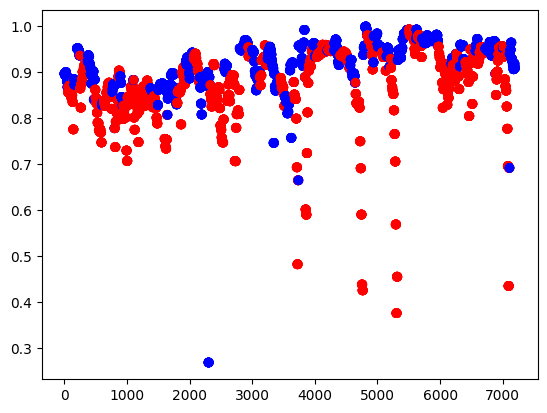

In [52]:
# Assuming gt is a numpy array or a list
gt = np.array(gt)  # Ensure gt is a numpy array for vectorized operations

# Generate color list based on gt values
c = np.where(gt == 0, 'b', 'r')

# Plot using plt.scatter
plt.scatter(np.arange(len(gt)), norm_score, color=c)
plt.show()

In [53]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,confusion_matrix
auc=0
thres=0
i=0.6
while i<1:
    print(i)
    y_pred=[1 if x<i else 0 for x in norm_score]
    y_pred=np.array(y_pred)
    a=roc_auc_score(gt,y_pred)
    if a>auc:
        auc=a
        thres=i
    i+=0.0001
    
print('For threshold={} AUC={}'.format(thres,auc))

0.6
0.6001
0.6002
0.6003
0.6003999999999999
0.6004999999999999
0.6005999999999999
0.6006999999999999
0.6007999999999999
0.6008999999999999
0.6009999999999999
0.6010999999999999
0.6011999999999998
0.6012999999999998
0.6013999999999998
0.6014999999999998
0.6015999999999998
0.6016999999999998
0.6017999999999998
0.6018999999999998
0.6019999999999998
0.6020999999999997
0.6021999999999997
0.6022999999999997
0.6023999999999997
0.6024999999999997
0.6025999999999997
0.6026999999999997
0.6027999999999997
0.6028999999999997
0.6029999999999996
0.6030999999999996
0.6031999999999996
0.6032999999999996
0.6033999999999996
0.6034999999999996
0.6035999999999996
0.6036999999999996
0.6037999999999996
0.6038999999999995
0.6039999999999995
0.6040999999999995
0.6041999999999995
0.6042999999999995
0.6043999999999995
0.6044999999999995
0.6045999999999995
0.6046999999999995
0.6047999999999994
0.6048999999999994
0.6049999999999994
0.6050999999999994
0.6051999999999994
0.6052999999999994
0.6053999999999994
0.6054